In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Train Dataset

In [ ]:
train = pd.read_csv("/kaggle/input/breakthrough-tech-ai-studio-challenge/train.csv")
train.head()

In [ ]:
train.shape

In [ ]:
#split "userId_movieId" column to two 'userId', 'movieId'
train[['userId', 'movieId']] = train["userId_movieId"].apply(lambda x: pd.Series(str(x).split("_")))
train = train.drop('userId_movieId', axis=1)
train.head()

In [ ]:
#Check for the dtypes and null values in our columns 
train.info()

In [ ]:
#change the datatype of the id columns from object to integers
train = train.astype({"userId":"int","movieId":"int"})

In [ ]:
train.info()

## Create a User- Items Interactions Matrix - Collaborative Filtering method

Model based collaborative approaches only rely on user-item interactions information and assume a latent model supposed to explain these interactions. Matrix factorization algorithms consists in decomposing the huge and sparse user-item interaction matrix into a product of two smaller and dense matrices: a user-factor matrix (containing users representations) that multiplies a factor-item matrix (containing items representations).

### Singular Value Decomposition (SVD)

In [ ]:
movies = pd.get_dummies(train['movieId'], prefix = 'movie')
movies = movies[list(movies.columns)].multiply(train['rating'], axis = 0)
movies

In [ ]:
train["userId"]

In [ ]:
movies.shape

In [ ]:
movies_joined = train.copy()
movies_joined = movies_joined.join(movies)
movies_joined.drop(columns = ['movieId','rating'], inplace = True)
movies_joined.sort_values('userId', inplace = True, ignore_index = True)
movies_joined.head()

In [ ]:
unique_users = np.unique(movies_joined['userId'])
unique_users

In [ ]:
user_item_matrix = pd.DataFrame(0, index=np.arange(len(unique_users)), columns=list(movies_joined.columns))
user_item_matrix

In [ ]:
for i,user in enumerate(unique_users):
    user_item_matrix.iloc[i] = movies_joined.loc[np.where(movies_joined['userId'] == user)].sum()

In [ ]:
user_item_matrix

In [ ]:
# renaming the column "A"
user_item_matrix.rename(columns = {"userId": "Number of Interactions"}, 
          inplace = True)

In [ ]:
num_user_interactions = user_item_matrix["Number of Interactions"]
num_user_interactions

In [ ]:
user_item_matrix = user_item_matrix.drop(['Number of Interactions'], axis=1)
user_item_matrix

In [ ]:
user_item_matrix_np = user_item_matrix.to_numpy()
user_item_matrix_np

In [ ]:
from numpy.linalg import svd

u, sigma, v = svd(user_item_matrix_np)
u.shape, sigma.shape, v.shape

In [ ]:
X = u.dot(np.diag(sigma))
X

## Movie Keywords

In [3]:
movie_keywords = pd.read_csv('/kaggle/input/breakthrough-tech-ai-studio-challenge/movies_keywords.csv')
movie_keywords

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/breakthrough-tech-ai-studio-challenge/movies_keywords.csv'

In [ ]:
movie_keywords.shape

In [ ]:
first_line = movie_keywords.keywords.iloc[0]
first_line

In [ ]:
#find empty strings in movie_keywords
movie_keywords.keywords.isnull().values.any()

#However we know from looking at the data that some objects are empty -> further investigation need to happen

In [ ]:
#There are 14750 values that have no useful keywords -> bring it up in todays meeting
# Question: what do you think we should do about them?
movie_keywords[movie_keywords.keywords == '[]'].shape[0]

In [ ]:
movies_metadata = pd.read_csv('/kaggle/input/breakthrough-tech-ai-studio-challenge/movies_metadata.csv')
movies_metadata

In [ ]:
movies_metadata.shape

In [ ]:
movies_metadata.info()

In [ ]:
#remove missing values
# drop columns homepage, belongs_to_collection
# Question -> show we also drop tagline column? 
movies_metadata = movies_metadata.drop(['homepage', 'belongs_to_collection', 'tagline'], axis=1)
movies_metadata

In [ ]:
movies_metadata.isnull().values.any()

In [ ]:
movies_metadata.isna().sum()

In [ ]:
movies_metadata.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90)


In [ ]:
column_name_num = list(movies_metadata.select_dtypes(include=[np.number]))
column_name_num

In [ ]:
#fill the missing values in popularity, vote_average, runtime, revenue, vote_count with the mean value
popularity_mean = movies_metadata.popularity.mean()
vote_average_mean = movies_metadata.vote_average.mean()
runtime_mean = movies_metadata.runtime.mean()
revenue_mean = movies_metadata.revenue.mean()
vote_count_mean = movies_metadata.vote_count.mean()

movies_metadata.popularity.fillna(value=popularity_mean, inplace=True)
movies_metadata.vote_average.fillna(value=vote_average_mean, inplace=True)
movies_metadata.runtime.fillna(value=runtime_mean, inplace=True)
movies_metadata.revenue.fillna(value=revenue_mean, inplace=True)
movies_metadata.vote_count.fillna(value=vote_count_mean, inplace=True)

In [ ]:
movies_metadata.isna().sum() 

In [ ]:
#indexes of rows with missing values in column overview
# movies_metadata[movies_metadata['overview'].isnull()].index.tolist()

In [ ]:
#remove rows with nul values in column title, video, production_countries, production_companies, spoken_languages -> theay are the same row
print(movies_metadata[movies_metadata['title'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['video'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['production_countries'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['production_companies'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['spoken_languages'].isnull()].index.tolist())

movies_metadata = movies_metadata.drop([19676, 29435, 35512])
movies_metadata

In [ ]:
movies_metadata.isna().sum() 

In [ ]:
#find the percentage of missing values in all columns
movies_metadata.isnull().mean() * 100

# as all the other columns' missing data are less than 5% we can ignore them

In [ ]:
movies_metadata.genres[0]

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer()
# y = pd.DataFrame(mlb.fit_transform(movies_metadata.genres), columns=mlb.classes_)

# movies_metadata = movies_metadata.join(y)
# movies_metadata.head()
# df.drop('label', inplace=True, axis=1)
# df.to_csv('doc-tc/encoded_data.csv', index=False)

In [ ]:
#Multiple labels columns: spoken_languages, genres, production_countries,
movies_metadata.info

# Movie Metadata 

In [4]:
movies_metadata = pd.read_csv("movies_metadata.csv.zip", compression='zip')

In [5]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
#find correlation
movies_metadata.corr(method ='spearman')

/var/folders/w7/j3fz6cgn5zxg68xkx083fknc0000gn/T/ipykernel_8716/2230254551.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  movies_metadata.corr(method ='spearman')


,adult,budget,id,popularity,revenue,runtime,vote_average,vote_count
adult,1.000000,-0.002919,0.011587,-0.002317,-0.005833,-0.007637,-0.012516,-0.003425
budget,-0.002919,1.000000,-0.255846,0.463109,0.644284,0.227116,0.072281,0.483987
id,0.011587,-0.255846,1.000000,-0.393352,-0.305056,-0.236748,-0.155182,-0.395348
popularity,-0.002317,0.463109,-0.393352,1.000000,0.490988,0.307875,0.242838,0.893756
revenue,-0.005833,0.644284,-0.305056,0.490988,1.000000,0.254345,0.127084,0.513059
runtime,-0.007637,0.227116,-0.236748,0.307875,0.254345,1.000000,0.194161,0.291237
vote_average,-0.012516,0.072281,-0.155182,0.242838,0.127084,0.194161,1.000000,0.319083
vote_count,-0.003425,0.483987,-0.395348,0.893756,0.513059,0.291237,0.319083,1.000000


In [7]:
movies_metadata.shape

(45383, 24)

In [8]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45383 entries, 0 to 45382
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45383 non-null  bool   
 1   belongs_to_collection  4486 non-null   object 
 2   budget                 45383 non-null  int64  
 3   genres                 45383 non-null  object 
 4   homepage               7765 non-null   object 
 5   id                     45383 non-null  int64  
 6   imdb_id                45383 non-null  object 
 7   original_language      45372 non-null  object 
 8   original_title         45383 non-null  object 
 9   overview               44433 non-null  object 
 10  popularity             45380 non-null  float64
 11  poster_path            45005 non-null  object 
 12  production_companies   45380 non-null  object 
 13  production_countries   45380 non-null  object 
 14  release_date           45302 non-null  object 
 15  re

In [9]:
#remove missing values
# drop columns homepage, belongs_to_collection
# Question -> show we also drop tagline column? 
movies_metadata = movies_metadata.drop(['homepage', 'belongs_to_collection', 'tagline'], axis=1)
movies_metadata

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45378,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",176269,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,...,"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,False,4.0,1.0
45379,False,0,"[{'id': 18, 'name': 'Drama'}]",176271,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,...,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,False,9.0,3.0
45380,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",176273,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Betrayal,False,3.8,6.0
45381,False,0,[],176275,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,...,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,Satan Triumphant,False,0.0,0.0


In [11]:
movies_metadata.isna().sum()

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                   0
original_language        11
original_title            0
overview                950
popularity                3
poster_path             378
production_companies      3
production_countries      3
release_date             81
revenue                   3
runtime                 258
spoken_languages          3
status                   83
title                     3
video                     3
vote_average              3
vote_count                3
dtype: int64

<AxesSubplot: xlabel='index'>

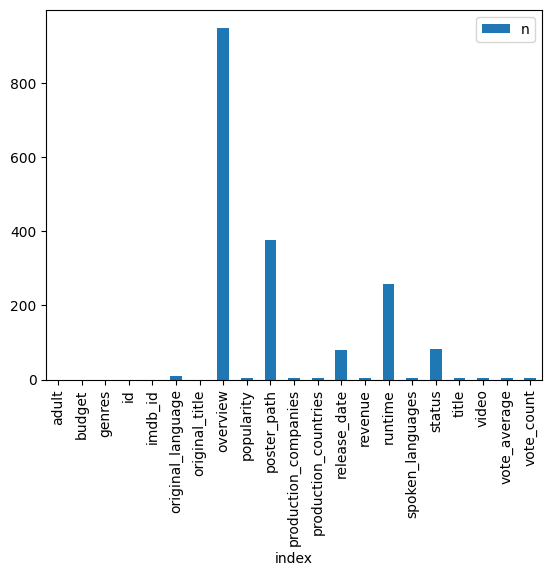

In [12]:
movies_metadata.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90)


In [13]:
column_name_num = list(movies_metadata.select_dtypes(include=[np.number]))
column_name_num

['budget',
 'id',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count']

In [14]:
#fill the missing values in popularity, vote_average, runtime, revenue, vote_count with the mean value
popularity_mean = movies_metadata.popularity.mean()
vote_average_mean = movies_metadata.vote_average.mean()
runtime_mean = movies_metadata.runtime.mean()
revenue_mean = movies_metadata.revenue.mean()
vote_count_mean = movies_metadata.vote_count.mean()

movies_metadata.popularity.fillna(value=popularity_mean, inplace=True)
movies_metadata.vote_average.fillna(value=vote_average_mean, inplace=True)
movies_metadata.runtime.fillna(value=runtime_mean, inplace=True)
movies_metadata.revenue.fillna(value=revenue_mean, inplace=True)
movies_metadata.vote_count.fillna(value=vote_count_mean, inplace=True)

In [15]:
movies_metadata.isna().sum() 

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                   0
original_language        11
original_title            0
overview                950
popularity                0
poster_path             378
production_companies      3
production_countries      3
release_date             81
revenue                   0
runtime                   0
spoken_languages          3
status                   83
title                     3
video                     3
vote_average              0
vote_count                0
dtype: int64

In [16]:
#remove rows with nul values in column title, video, production_countries, production_companies, spoken_languages -> theay are the same row
print(movies_metadata[movies_metadata['title'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['video'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['production_countries'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['production_companies'].isnull()].index.tolist())
print(movies_metadata[movies_metadata['spoken_languages'].isnull()].index.tolist())

movies_metadata = movies_metadata.drop([19676, 29435, 35512])
movies_metadata

[19676, 29435, 35512]
[19676, 29435, 35512]
[19676, 29435, 35512]
[19676, 29435, 35512]
[19676, 29435, 35512]


,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45378,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",176269,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,...,"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,False,4.0,1.0
45379,False,0,"[{'id': 18, 'name': 'Drama'}]",176271,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,...,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,False,9.0,3.0
45380,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",176273,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Betrayal,False,3.8,6.0
45381,False,0,[],176275,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,...,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,Satan Triumphant,False,0.0,0.0


In [17]:
movies_metadata.isna().sum() 

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                   0
original_language        11
original_title            0
overview                950
popularity                0
poster_path             375
production_companies      0
production_countries      0
release_date             78
revenue                   0
runtime                   0
spoken_languages          0
status                   80
title                     0
video                     0
vote_average              0
vote_count                0
dtype: int64

In [18]:
#find the percentage of missing values in all columns
movies_metadata.isnull().mean() * 100

# as all the other columns' missing data are less than 5% we can ignore them

adult                   0.000000
budget                  0.000000
genres                  0.000000
id                      0.000000
imdb_id                 0.000000
original_language       0.024240
original_title          0.000000
overview                2.093433
popularity              0.000000
poster_path             0.826355
production_companies    0.000000
production_countries    0.000000
release_date            0.171882
revenue                 0.000000
runtime                 0.000000
spoken_languages        0.000000
status                  0.176289
title                   0.000000
video                   0.000000
vote_average            0.000000
vote_count              0.000000
dtype: float64

#### Reset index from removing data

In [19]:
movies_metadata = movies_metadata.reset_index(drop=True)
movies_metadata.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0


### Correct genres columns - Multilabel Binerizer

In [21]:
for i in range(len(movies_metadata.genres)):
    genres_list = []
    genres = eval(movies_metadata.genres[i])
    for key, value in [(key, value) for x in genres for (key, value) in x.items()]:
        if key == "name":
            genres_list.append(value)
#     print(genres_list)
    movies_metadata.at[i, 'new_genres'] = (genres_list)

In [22]:
movies_metadata.isnull().sum()


adult                     0
budget                    0
genres                    0
id                        0
imdb_id                   0
original_language        11
original_title            0
overview                950
popularity                0
poster_path             375
production_companies      0
production_countries      0
release_date             78
revenue                   0
runtime                   0
spoken_languages          0
status                   80
title                     0
video                     0
vote_average              0
vote_count                0
new_genres                0
dtype: int64

In [23]:
movies_metadata.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,new_genres
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]"
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,"[Adventure, Fantasy, Family]"
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,"[Romance, Comedy]"
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,"[Comedy, Drama, Romance]"
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,[Comedy]


In [24]:
movies_metadata.new_genres

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45375                 [Drama, Family]
45376                         [Drama]
45377       [Action, Drama, Thriller]
45378                              []
45379                              []
Name: new_genres, Length: 45380, dtype: object

### Create new df of multilabel binerized data

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit_transform(movies_metadata.new_genres)
list(mlb.classes_)

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [26]:
movie_genres = pd.DataFrame(mlb.fit_transform(movies_metadata.new_genres), columns=mlb.classes_)

In [27]:
movie_genres.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Correct production_companies Multilable Binerizer

In [29]:
for i in range(len(movies_metadata.production_companies)):
    companies_list = []
    companies = eval(movies_metadata.production_companies[i])
    for key, value in [(key, value) for x in companies for (key, value) in x.items()]:
        if key == "name":
            companies_list.append(value)
#     print(genres_list)
    movies_metadata.at[i, 'new_production_companies'] = (companies_list)

In [30]:
movies_metadata.new_production_companies

0                                [Pixar Animation Studios]
1        [TriStar Pictures, Teitler Film, Interscope Co...
2                           [Warner Bros., Lancaster Gate]
3                 [Twentieth Century Fox Film Corporation]
4             [Sandollar Productions, Touchstone Pictures]
                               ...                        
45375                                                   []
45376                                        [Sine Olivia]
45377                            [American World Pictures]
45378                                          [Yermoliev]
45379                                                   []
Name: new_production_companies, Length: 45380, dtype: object

### Create a multilabel binerized data - production_companies

In [34]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(movies_metadata.new_production_companies)
list(mlb.classes_)

['"DIA" Productions GmbH & Co. KG',
 '# Andrea Sperling Productions',
 '# Lexyn Productions',
 "'A' Production Committee",
 '(주)로드픽쳐스',
 '(주)로제타시네마',
 '(주)비에이엔터테인먼트',
 ', Flaminia Produzioni Cinematografiche',
 ', Planet Productions',
 '.406 Production',
 '01 Distribution',
 '1.85 Films',
 '10 West Studios',
 '100 Bares',
 '100 Feet Productions',
 '100 doo',
 '100% Halal',
 '100% Synthetic Films',
 '1000 Volt',
 '1019 Entertainment',
 '101st Street Films',
 '108 Media',
 '108 Sound Studio',
 '10dB Inc.',
 '10th Hole Productions',
 '11:11 Mediaworks',
 '12 Gauge Productions',
 '120 Films',
 '1201',
 '120dB Films',
 '129 Productions',
 '13 All Stars LLC',
 '13 Ghosts Productions Canada Inc.',
 '13 Productions',
 '13 TV',
 '13th Dimensional Video',
 '14 Luglio Cinematografica',
 '14 Reels Entertainment',
 '141 Entertainment',
 '1428 Films',
 '1492 Pictures',
 '16 Block Productions',
 '1600 Limited Partnership',
 '1618 Action Limited',
 '1718 Studio',
 '180 Degrees',
 '1812 Productions',
 

In [32]:
movie_companies = pd.DataFrame(mlb.fit_transform(movies_metadata.new_production_companies), columns=mlb.classes_)

In [33]:
movie_companies.head()

,"""DIA"" Productions GmbH & Co. KG",# Andrea Sperling Productions,# Lexyn Productions,'A' Production Committee,(주)로드픽쳐스,(주)로제타시네마,(주)비에이엔터테인먼트,", Flaminia Produzioni Cinematografiche",", Planet Productions",.406 Production,...,롯데엔터테인먼트,쇼박스(주)미디어플렉스,싸이더스 픽쳐스,씨너스엔터테인먼트(주),영화사 수박,영화사 집,이디오플랜,인벤트 디,타임스토리그룹,프로덕션M
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Correct production_countries Multilable Binerizer

In [35]:
movies_metadata.production_countries

0        [{'iso_3166_1': 'US', 'name': 'United States o...
1        [{'iso_3166_1': 'US', 'name': 'United States o...
2        [{'iso_3166_1': 'US', 'name': 'United States o...
3        [{'iso_3166_1': 'US', 'name': 'United States o...
4        [{'iso_3166_1': 'US', 'name': 'United States o...
                               ...                        
45375               [{'iso_3166_1': 'IR', 'name': 'Iran'}]
45376        [{'iso_3166_1': 'PH', 'name': 'Philippines'}]
45377    [{'iso_3166_1': 'US', 'name': 'United States o...
45378             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
45379     [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
Name: production_countries, Length: 45380, dtype: object

In [37]:
for i in range(len(movies_metadata.production_countries)):
    countries_list = []
    countries = eval(movies_metadata.production_countries[i])
    for key, value in [(key, value) for x in countries for (key, value) in x.items()]:
        if key == "iso_3166_1":
            countries_list.append(value)
#     print(genres_list)
    movies_metadata.at[i, 'new_production_countries'] = (countries_list)

### Create a multilabel binerized data - production_countries

In [38]:
movie_countries = pd.DataFrame(mlb.fit_transform(movies_metadata.new_production_countries), columns=mlb.classes_)

In [39]:
movie_countries.head()

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,UY,UZ,VE,VN,WS,XC,XG,YU,ZA,ZW
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Correct spoken_languages Multilable Binerizer

In [40]:
movies_metadata.spoken_languages

0                 [{'iso_639_1': 'en', 'name': 'English'}]
1        [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2                 [{'iso_639_1': 'en', 'name': 'English'}]
3                 [{'iso_639_1': 'en', 'name': 'English'}]
4                 [{'iso_639_1': 'en', 'name': 'English'}]
                               ...                        
45375               [{'iso_639_1': 'fa', 'name': 'فارسی'}]
45376                    [{'iso_639_1': 'tl', 'name': ''}]
45377             [{'iso_639_1': 'en', 'name': 'English'}]
45378                                                   []
45379             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 45380, dtype: object

In [53]:
for i in range(len(movies_metadata.spoken_languages)):
    spoken_languages_list = []
    spoken_languages = eval(movies_metadata.spoken_languages[i])
    for key, value in [(key, value) for x in spoken_languages for (key, value) in x.items()]:
        if key == "iso_639_1":
#             print(value)
            spoken_languages_list.append(value)
    print(spoken_languages_list)
    movies_metadata.at[i, 'new_spoken_languages'] = (spoken_languages_list)

['en']
['en', 'fr']
['en']
['en']
['en']
['en', 'es']
['fr', 'en']
['en', 'de']
['en']
['en', 'ru', 'es']
['en']
['en', 'de']
['en']
['en']
['en', 'la']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'de']
['en', 'es', 'nl']
['en']
['en']
['en']
['en']
['en']
['cn', 'fr']
['zh']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['ru', 'en']
['en']
['es', 'en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['es', 'en', 'fr', 'hu']
[]
['en']
['sq', 'it']
['en', 'de']
['en']
['en']
['en', 'es']
['it', 'es']
['en', 'fr']
['en']
['en', 'fr', 'ko', 'es']
['en']
['en', 'es']
['en']
['en', 'ru']
['en', 'hu']
['en']
['fr', 'es']
['en']
['en', 'es']
['en', 'es']
['en']
['fr']
['en']
['en']
['en']
['de', 'en']
['en']
['en']
['fa']
['en']
['nl']
['en']
[]
['en']
['da', 'en', 'fr', 'de']
['en', 'fr', 'ru']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['fr']
['en']
['en']
['en']
['es', 'en']
['en']
['en']
['en']
['en']
['de']
['en']
['en']
[]
['en', 'fr', 'la

['en']
[]
['en']
[]
['en']
['en']
['en', 'es']
['en']
['en', 'fr', 'de', 'sv', 'it', 'ru']
['de', 'en', 'da', 'zh', 'cn']
['en']
['fr']
['en']
['en', 'fr']
['en']
['en']
['en']
['en', 'zh', 'bo']
['en']
['en', 'he', 'es', 'de']
['en', 'fr']
['fr']
['en']
['en', 'fr', 'de']
['en']
['en']
[]
['en']
['en', 'pt']
['sq', 'en']
['en']
['en']
['en']
['en']
['en', 'tr']
['en']
['en']
['en', 'de']
['zh', 'cn']
['en', 'pt']
['en']
['ko', 'en']
[]
['en']
['en']
['ru']
['cn', 'cs', 'en']
['fr', 'en', 'it']
['en']
['ru', 'en']
['en', 'ja']
['en']
['en']
['en']
['en']
['en', 'gd', 'es']
[]
['en', 'de', 'ru']
['en']
['en', 'es']
[]
['en']
['en']
['en']
['en']
['en']
['es']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['ja']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'zh']
['en']
['ja', 'en']
['en']
['en']
['en', 'pl']
['en']
['es', 'en']
['en']
['en']
['en']
['en']
['en', 'fr']
['es']
['en']
['en']
['en']
[

['en']
['en']
['en']
[]
['en']
['en']
['en']
['ja']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
[]
['en', 'es']
['en', 'ru']
['en']
[]
['en']
['en', 'fr', 'gd']
['en']
['en']
['de', 'la']
['es', 'en']
['es']
['vi', 'en']
['en', 'fr']
['en']
['en']
['es', 'en']
['en']
['en']
['fr', 'es']
[]
['en']
['en']
['en', 'it', 'es']
['en']
['en']
['pt', 'en']
['en']
['en']
['en']
[]
['en', 'fr', 'ru']
['en']
['en']
['en']
['en']
['en']
['en', 'fr', 'de']
['en']
['en']
['en', 'fr']
['en']
['en', 'hu']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'hu']
['en']
['de', 'en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'ru', 'es']
['en']
['en', 'it']
['en']
['cn']
['en']
['en', 'de']
['en']
['en', 'fr']
['en', 'de', 'f

['en']
['en']
['en']
['en', 'de']
['en']
['en', 'es']
['en', 'de']
['en']
['en']
['en', 'es']
['en']
['en']
['vi', 'en']
['en']
['en']
['en']
['en', 'it']
['en', 'hi']
['en']
['en']
['de', 'en']
['en', 'es']
['en']
['en']
['cs']
['en']
['en']
['hu', 'cs']
['ja']
['la', 'sv']
['en']
['en']
['en']
['en']
['en', 'vi', 'fr']
['en', 'fr']
['en']
['en']
['en']
['hu', 'it', 'la', 'en']
['en']
['en']
['it', 'es']
['en']
['en']
['en']
['en']
['en', 'it']
['en']
['en']
['hu', 'en']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en', 'de']
['en', 'fr', 'de', 'pl', 'ru']
['en']
['en']
['en', 'fr', 'de']
['en']
['en', 'de']
['en']
['en']
['en']
['sr']
['fr']
['en', 'fr', 'es']
['en']
['fr', 'en']
['en', 'sv']
['en']
['it']
['fr']
['en']
['en', 'fr', 'de']
['en']
['en']
['en', 'fr']
['en']
['fr', 'de', 'it']
['en']
['en']
['en']
['en']
['en', 'de']
['es']
['en']
['en']
['en']
['en']
['hr', 'en', 'fr', 'sr']
['en']
['nl']
['ar', 'en', 'he']
['

['en']
['en', 'ja']
['cs', 'en']
['en', 'es']
['en', 'es']
['en', 'hu', 'es']
['en']
['fr']
['en', 'de', 'es']
['cs', 'en']
['cs', 'en', 'de']
['en']
['it']
['en', 'fr', 'es']
['en']
['en']
['en']
['en']
['fr']
['en', 'he', 'yi']
['en']
['en']
['en']
['en', 'zh']
['en']
['en', 'de', 'it', 'la', 'pl', 'ru']
['en']
['en']
['fr', 'en']
['en']
['en']
['en', 'fr', 'de', 'hu', 'it', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
['fr']
['en']
['es', 'en']
['en']
['ru']
['en', 'fr']
[]
['en']
['es']
['en', 'fr', 'de']
['en', 'de']
['en']
['en']
['en']
['es', 'en']
['en', 'zh', 'es']
['it']
['en']
['en', 'it', 'ja', 'zh']
['en']
['en', 'ja']
['ar', 'de']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'hu']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'hu']
['en', 'el', 'ru']
['en']
['ja']
['en']
['en']
['en', 'es']
['en', 'fr']
['de', 'en', 'pl']
['en']
['en']
['en', 'es']
['en']
['cn', 'en', 'it']
['en']
['en', 'fr']
['en']
['pt']
['en', 'de', 'it']
['fi', 'de', 'ru']
['ar

['en']
['en']
['en']
['en']
['en', 'it']
['es', 'en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['it']
['en']
['en']
['en', 'zh', 'es', 'cn']
['en']
['en']
['es']
['en']
[]
['en', 'fr', 'pt']
['en', 'es']
['en', 'fr', 'ro', 'es']
['en']
['en']
['en']
['en']
['sw', 'en', 'de', 'vi']
['en']
['en']
['en', 'la']
['en']
['es']
['en']
['en']
['fr', 'pt']
['en']
['fr']
['en']
['en']
['fi']
['en']
['en']
['en']
['en']
['en']
['cn', 'en']
['pt']
['en']
['ja']
['cn', 'zh', 'es']
['en']
['en']
['de']
['fr']
['en']
['en']
['en']
['da', 'it', 'sv']
['en']
['en']
['en']
['fr']
['en']
['en']
['en']
['en', 'fr', 'de', 'ru']
['en']
['ja']
['en']
['en']
['en']
['en', 'ja', 'ru']
['de', 'en', 'ru', 'es']
['en']
['en']
['en', 'fr', 'ar', 'es']
['ja']
['sv']
['en', 'fr']
['en']
['en', 'de', 'it']
['hu', 'en']
['en']
['en']
['en']
['en', 'it']
['nl', 'en', 'de']
['fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['fr', 'es']
['pt']
['de']
['

['en']
['en']
['en']
['en', 'pt', 'es']
['en']
['en']
['en']
['es', 'en']
['en']
['en']
['en']
['de', 'en']
['en']
['en']
['en']
['en']
['en']
['en']
['ja']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ja']
['en']
['en']
['en']
['en']
['en']
['ja', 'en']
['de', 'en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'de']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['da']
['en']
['en']
['en', 'fr']
['sv']
['en']
['en']
['en']
['en']
['en']
['en', 'fr', 'de', 'es']
['de', 'en', 'fr']
['en']
['en']
['en']
['ru']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en', 'it']
['en']
['en']
['en']
['en']
['en']
['en']
['es', 'en']
['en']
['en']
['en', 'fr', 'it']
['en', 'es']
['cn', 'en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['fr']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['es']
['ja']
['en']
['en', 'it']
['en']
['en']
['en']
['en']
['ja']
['en']
['en']
['en', 'es']
['ja']
['en']
['en']
['en']
['ja']
['fr', 'it']
[

['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en', 'zh']
['en']
['en']
['en', 'el', 'es']
['en', 'es']
['fr']
['en']
['en', 'es']
['en']
['it', 'en', 'fr']
['en']
['hi']
['fr']
['en', 'fr', 'de', 'pl']
['en']
['en']
['en']
['es']
['en', 'ja']
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['en', 'ur', 'zh']
['ja']
['ja', 'en', 'cn']
['en', 'fr', 'de']
['en', 'de']
['en']
['en', 'he', 'es']
['en', 'it']
['en']
['en']
['en']
['en']
['en', 'fr', 'it', 'pl', 'es']
['en', 'es']
['en']
['ar', 'fr', 'es']
[]
['en', 'fr']
['it']
['en']
['en']
['es']
['cn', 'ja', 'ko', 'zh']
['fr']
['it', 'de']
['de']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en', 'sh']
['en']
['en']
['en']
['en', 'sv']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'ru']
['en', 'la']
['it']
['it']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ja']
['ar', 'en', 'fr', 'de', 'hu']
['en']
['fr', 'en']
['en', 'fr']
['en']
['en', 'pt']
['en']
['en']
['he']
['en']
['en']
['fr']
['en']
[

['en']
['es']
['en', 'ru']
['en', 'es', 'ko']
['en']
['en']
['en']
['fr']
['fr']
['en']
['en']
['xx']
['es']
['en']
['en']
['en']
['de', 'fr', 'ar']
['en', 'fr', 'es']
['en']
['en']
['zh']
['en']
['en', 'pt']
['en']
['en', 'fr']
['af', 'en']
['en']
['en', 'de']
['en']
['cn', 'zh']
['en']
['en']
['en']
['en']
['en', 'es']
['fa']
['en']
[]
['en']
['en']
['en', 'ru']
['en', 'hi', 'ko', 'zh']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
['en', 'de', 'la', 'es']
['en']
['fr', 'zh', 'en']
['en']
['ja']
['en']
['en', 'ru', 'es', 'de', 'ln']
['en']
['fr']
['en']
['en', 'fr', 'de', 'pt']
['de', 'it']
['en', 'es']
['en']
['en', 'fr', 'ko', 'ru']
['de']
['en', 'pl']
['la']
['en']
['en', 'fr', 'ru']
['en']
['en', 'fr']
['en']
['en']
['en']
['ar', 'fr']
['en']
['zh']
['no']
['en']
['en', 'de', 'zh', 'ru']
['en', 'de', 'hu', 'no']
['en', 'ja']
['en']
['en', 'it']
['en']
['ar', 'en', 'es']
['en']
['en']
['en']
['en']
['de', 'ko']
['en']
['en']
['es']
['fr']
['de', 'en', 'nl']
['en']
['en']
['zh']


['en', 'fr']
['en']
['en', 'fr']
['xx', 'en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['cn', 'ja', 'vi']
['de']
['cn', 'zh']
['en', 'he']
['hu']
['en', 'es']
['en']
['it']
['en', 'es']
['cn']
['en']
['en']
['en']
[]
['cn', 'en', 'fr']
['en']
['en']
['it']
['it']
['en']
['en']
['en']
['en']
['en']
['zh']
['en']
['en']
['en', 'fr']
['pt', 'es', 'en']
['en']
['ja', 'zh', 'en']
['ja']
['en']
['en']
['en', 'ja']
['en']
['en', 'fi', 'de', 'zh', 'es']
['en']
['en']
['en']
['en']
['en', 'ru']
['en', 'de']
[]
['en']
['en']
['en']
[]
['fr']
['es', 'en']
['en']
['en']
[]
['en']
['fr', 'ja']
['pl']
['ru']
['en']
['en']
[]
[]
['en']
['en']
['en', 'fr']
['en']
['en']
['bn']
['en']
[]
['en']
['en']
['en']
['en']
['en', 'zh']
['en']
['ja']
['en', 'de']
['en', 'es']
['en']
['cs', 'en']
['en']
['en']
['fr']
['fr']
['en']
['en']
['ja']
['fa']
['en', 'pl']
['en']
['en']
['en', 'fr', 'de']
['en']
['ar', 'en']
['ce', 'ru']
['en', 'fr', 'hu', 'it', 'ro']
['en', 'el']
['fi']
['fr']
['ja']
['en

['en']
[]
[]
['en', 'it']
['pl']
['en']
['es', 'en']
[]
['en']
['en']
['en']
['hi']
['en', 'de', 'tl', 'th']
['de']
['en', 'de']
['ja']
[]
['en']
['ko']
['en']
['en', 'fr']
['ja']
['en']
['en']
['en']
['pl', 'es']
[]
['en']
['en']
['en']
['en']
['en']
['ru']
['de']
['en']
['it']
['en']
['en', 'de']
['zh', 'th']
[]
['ro']
['fr']
['fi']
['cs', 'en', 'fr']
['pl']
['pl']
['en']
['en', 'pt']
['en']
['en']
['en']
['pl']
['en']
['en']
['en', 'it', 'la', 'fr', 'de', 'zh']
['en']
['it']
['en', 'es']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['fr']
['en', 'cn']
['en', 'it']
['en']
['de']
['en']
['en']
['en']
['en']
['en', 'fr', 'cs', 'ja']
['en']
['en']
['de', 'it']
['pl']
['pl']
['en', 'de', 'it']
['fr']
['fr']
['fr']
['en']
['en']
['en']
[]
['en']
['it']
['fr']
['en']
['en', 'fr']
['en']
['en']
['pl']
['ja']
['en', 'es', 'hu', 'cs']
['en']
['ja']
['de', 'ja']
['en']
['en']
['fr']
['xx']
['en', 'fr']
['en']
['en']
['

['en']
['cs', 'fr', 'it']
['en', 'ar']
['en', 'es']
['en']
['en']
['ar', 'he']
['de', 'en', 'fr', 'zh']
['en']
['en', 'fr']
['en']
['en', 'sr']
['en', 'pl', 'ru']
['en']
['en', 'la']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'ko']
['en']
['ko', 'zh']
['en']
['en']
['de']
['en']
['en']
['en']
['en', 'th']
['en']
['fr']
['en']
['en', 'es']
['en']
['en']
['ja']
['it']
['en']
['fi']
['sv']
['en']
['fi']
['fi']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'it']
['en']
['en']
['en']
['en']
['en']
['it']
['el', 'en']
['en']
['en']
['en']
['en', 'fr']
['de', 'fr', 'it']
['en']
['en']
['ru', 'en', 'pl']
['en']
['fi']
['en']
['en']
[]
['hi']
['fr']
['en', 'hi']
['en', 'ru']
['it']
['en']
['ru', 'en']
['en']
['en']
['en']
['bg']
[]
['ko']
['en']
['en']
['de', 'fa']
['ko']
['en', 'de', 'hu']
['en']
['en']
['bg', 'en']
['hi']
['en', 'it']
['da', 'en', 'fr', 'el', 'ja', 'zh', 'no', 'sv']
['de', 'ru', 'sr']
['en']
['en', 'pl']
['sl', 'en']
[

['pl']
['en']
['en']
['en']
['en']
['en']
['it', 'en']
['en']
['en', 'es']
['en']
['hi']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en', 'fr', 'it', 'ru', 'es']
['en']
['en']
['en']
['en']
['en', 'fi']
['en']
[]
['en', 'fr', 'de']
['fr', 'de', 'el', 'ru']
['fr']
['ja']
['it']
['en', 'de', 'id', 'zh', 'ps', 'ru']
['en']
['en']
['en']
['en']
['fa']
['en']
['it']
['en', 'es']
['en']
['fr']
['tr']
['fr']
['tr']
['ru']
['ko']
['tl']
['xx']
['fr']
['xx']
['de']
['en']
['es']
['de']
['xx']
['en', 'it']
['en']
['en']
['it', 'sr']
['en']
['en']
['fi']
[]
['cs']
['en']
['xx']
[]
['en']
['es']
['en']
['fi']
['en']
['en']
['hi']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['es', 'en', 'mn', 'hi']
['en']
['ko']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'ro']
['en']
['en']
[]
['en']
['ko']
['ja']
['es']
['fr']
['zh']
['en']
['ko']
['it']
['es']
['en', 'fr', 'es']
['en', 'fr']
['fr']
['en']
['en'

['en']
[]
['en']
['en']
['it']
['en']
['fr']
['en', 'de']
['en']
['en']
['sv']
['da']
['en']
[]
['en']
['en']
['en', 'it']
['en']
['en']
['hu', 'en']
['en']
['en']
['en']
['en']
['en', 'it']
['en']
['es']
['en']
[]
['fr', 'de']
['zh']
['fr']
['ja']
['fr']
['fr', 'it']
['en']
['cs']
['en']
[]
['ja']
['xx']
['cs']
['en']
['zh']
['en']
['en']
['en']
['en']
['en']
['pl']
['en']
['de']
[]
['el', 'en']
['en']
['zh', 'en']
['en']
[]
['zh']
['xx']
['en']
['en']
['en']
['en']
['fr']
['en']
['ru']
['ko']
['en', 'es']
['en']
['no', 'en']
['ru']
['fr']
[]
['en']
['en']
['en']
['de', 'sh', 'en', 'bs']
['en']
['en', 'fr', 'de']
[]
['fr', 'zh', 'pl']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['fr']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['zh']
['en', 'pt']
['ar', 'en', 'fr', 'de']
['en']
[]
['en']
['th', 'en']
['en', 'de', 'es']
['en']
['en']
['fr']
['en']
[]
[]
[]
['fr', 'en']
['en']
['es']
['fr']
['en']
['it']
['en']
['es', 'fr']
['en']
['fr']
['pt

['en', 'pt']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['de', 'en']
['en']
[]
['en']
['en', 'pt']
['en']
['en']
['en']
['hi', 'en']
[]
['ru']
['en']
['ja']
['en']
[]
['en']
['en', 'fa']
['en', 'vi']
['it', 'en']
['en']
['en']
['en']
['en']
['it']
[]
['en']
[]
['en']
['en']
[]
['en', 'fr', 'de', 'it']
['en']
['en']
['en']
[]
['ja', 'la']
['de']
['en', 'fr']
['en']
['en']
['en']
['ja']
[]
['en']
['en']
['en']
['en']
['ja']
['it']
['fr']
['sv']
['en']
['en']
['en']
['de', 'fr', 'en']
['en']
['en']
['fr']
['ja']
['en']
['en']
['fr', 'ca', 'es']
['en']
['hi']
['en']
['en']
['es', 'en']
['fr']
['en']
['en', 'es']
['en']
[]
['en']
['es']
['fr']
['en', 'de']
['en', 'fr']
['en', 'pl']
['fr']
['en']
['pl']
['en']
['da']
['en', 'zh']
['it']
['ja']
['en']
['en']
['ja']
['en']
['en']
['en']
['en']
['en', 'de']
['da', 'fr', 'sg', 'en']
['en']
[]
[]
['en']
['en', 'de']
['en']
[]
['fr']
['en']
['de']
['en']
['en']
['en']
['en']
[]
['en']
['en', 'it']
['en']
['en']
['de']
['fr', 'sv']
['d

['en']
['es']
['en']
[]
['en']
['en']
['en']
['en']
['en', 'de']
['en']
['en']
['pl']
['sv']
['id']
['ms']
['hi']
['en', 'iu']
[]
['ja']
['ja']
[]
['en']
['en']
['en']
['en']
['en', 'ja']
['de']
['fr']
['ru']
['en', 'fr', 'es']
['en']
['en']
['en']
[]
['tr']
[]
['en', 'sv', 'is', 'ar']
['en']
['en']
['en']
['en']
['en']
['en', 'ro']
['fi']
['en']
['hi', 'ru', 'te']
['en']
['en', 'fr', 'ja']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en', 'it']
['en']
[]
['fi']
['en']
[]
['en']
['it', 'en', 'bs']
['en']
['en']
['no', 'sv']
['ja']
[]
['en']
['en']
['fr']
['lt', 'ru', 'en']
['pt', 'es']
['en']
['en']
['en']
['ja']
['en']
['fr']
['en']
['en']
['en']
['fr']
['en']
['en']
['en']
['en']
['en']
['fr', 'it']
['de', 'sr']
['en', 'fr']
['en']
['sv']
['ja']
['en']
['es']
['fr', 'en']
['en']
['en', 'it']
['en']
['de', 'en', 'fr']
[]
['cs']
[]
['en']
[]
['ko']
['en', 'af', 'xh']
['en']
['ja']
['ja']
['ja']
['en']
['ml']
['fr', 'it']
['fi']
['en']
['en']
['en']
['ja']
['en', 'fr']
['en']
['en']
[

['ja']
['en']
['la', 'en', 'pl']
['en']
['hi']
['it']
['en']
['en']
['en']
['ar', 'en', 'de']
['en', 'fr']
['en']
['es', 'en']
['es']
[]
['en']
['en']
['en', 'fr']
[]
['cn', 'zh']
['en']
['en']
['es']
['bn']
['de']
['da']
['es']
['ja']
['es', 'en']
['zh', 'en', 'fr', 'es', 'ko']
['en']
['jv', 'en']
['en']
['bs', 'de']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['en']
['bn']
['bn', 'en']
['ar']
['fr']
['ja']
['ja']
['en']
['en']
[]
['en', 'es']
['en']
['zh']
['en']
['en']
['en']
['en']
['it']
['en', 'fr']
['en']
[]
['fi']
['ja']
['ja']
['en']
['en']
['en']
['ja']
['ca', 'en', 'es']
['en']
['en']
['en']
['en']
['en']
[]
[]
['it', 'en', 'fr']
['en']
['en']
['en']
['en']
['en']
['es', 'en']
['en']
[]
['en']
['en']
['en']
['cn', 'en']
['de']
[]
[]
['en']
['en']
['en']
['en']
['en', 'fr', 'de']
['en']
['en']
['en']
['en']
['en']
['fr', 'en']
['en']
[]
['en']
[]
['en']
['en']
['tr', 'el', 'en']
['en']
['en']
['it']
['en']
['en']
['en']
['el']
['en']
['en']
['en']
['en']
['en']
['en']
['e

['zh', 'en']
['ru']
['en']
['en']
['cs', 'en', 'es']
['ja']
['en']
['en']
['en']
['en']
['en']
['de', 'en']
['en']
['en']
['en']
['fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ru']
['ru']
['ru']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'pl']
['ay', 'es']
['en']
['fi']
['en', 'fr']
['en', 'pl']
['en']
['en', 'de']
['en']
['en']
[]
['en']
['en']
['en', 'es']
[]
['en']
['en']
['en']
['en', 'it']
['en', 'es']
['cs', 'en']
['en']
['en', 'de']
['en']
['en']
['en']
['en']
['en']
['ja']
['en']
['ru']
['pl']
['bg', 'en', 'de', 'mk', 'sr']
['ja']
['ja']
['en', 'hu', 'ro', 'de']
['et', 'ka', 'ru']
['en']
[]
['ja']
['en']
['ja']
['en']
[]
['en', 'it']
['en']
['en']
[]
['ja']
[]
['es']
['en']
['cn']
['en']
['en']
['en']
['it']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
[]
['es']
[]
[]
['ar', 'he']
['es']
['en']
['en']
['es']
['cs', 'en', 'fr', 'pl']
[]
['en']
['nl']
['bg'

[]
['it']
['it']
['it']
['it']
['ko']
['ja']
['it']
['en']
['en']
['ja']
[]
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['es']
['en']
[]
['ar']
['es']
['en', 'it', 'sv']
['en']
['en']
['fr']
['fr']
['fr']
['fr']
['en', 'fr', 'de']
['en', 'ru']
['es']
['en', 'fr', 'gd']
['en']
['es']
['fi']
['en']
[]
['sv']
['de', 'it']
['en']
['en']
['fr']
['fr']
['fr']
['fr']
['fr']
['en']
['en']
['en']
['en']
['en']
['en']
['fr']
['en']
['en']
['fr']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en', 'fr']
['en']
['en']
['hi']
['en']
['en']
['en']
['en']
['ko']
[]
['fr']
['es']
['cn', 'zh']
['en']
['es', 'en']
['en']
['en']
['en']
['en', 'de']
['en']
['en', 'ru']
['no', 'en', 'fi', 'tr']
['en']
['en', 'id']
['en']
['en']
['en']
['cs', 'en', 'fr']
['en', 'de', 'ru']
['en']
['en']
['en']
['en']
['en']
['ko']
['en', 'pl']
['en']
['en']
['en']
['en']
['en']
['en', 'it']
['en', 'pl']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['fr', 'de', 'es']
['en']
['en']
[

['en']
['ru']
['en']
['en']
['en', 'es']
['en']
['en', 'es']
['ja']
['en']
['ja']
[]
['en']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['en']
['hu']
['en']
['ja']
['en']
['fr']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
[]
[]
['en']
['en']
['fr']
['en']
['en']
['fr']
[]
[]
['zh']
[]
['en']
['en', 'it']
[]
['es']
['en']
['en']
['en']
['en']
['en']
['es']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['ru', 'en']
['en']
['sv']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
[]
['en']
[]
['en', 'fr']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
[]
['es', 'en']
['ja']
['en']
['en']
['en']
['hi']
['en', 'de']
['en']
['en']
['en']
['fr', 'it']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'es']
['en']
['ko', 'en']
['en']
['en']
['en']
[]
['fi', 'sv']
['es']
['en']
['en', 'fr']
['es']
['en']
['ko']
['it']
['en'

[]
['pl']
['it']
['de', 'ja']
['fr']
['es']
['pt']
['en']
['en', 'tl']
['es']
['qu', 'es']
['fr']
[]
['en', 'es', 'sv']
['tl']
['tl']
['es']
['it']
['en']
['en']
['en']
['ru']
['en']
['en']
['en']
['en']
['en']
['en']
['it']
['fr']
[]
['fr', 'it']
['it']
['it']
['en']
['en']
['en']
['en']
['en']
['en']
['ja', 'th']
['fr']
['en']
['zh', 'cn', 'tl']
['en']
['en']
['en']
['ur']
['en']
['en']
['fr']
['es', 'en']
['fr']
['fr']
['fr']
['fr']
['fr']
['en']
['sr', 'en']
['en']
['en']
[]
[]
['en', 'fr']
['nl', 'en', 'de']
['ko']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['tr']
['en']
['en']
['en']
['en']
['en']
['ko']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['cn']
['en']
['sv']
['de', 'en', 'fr', 'es', 'zh']
['sl']
['sl']
['sl']
['sv', 'en']
[]
['fi']
['en', 'vi']
['de', 'en']
['xx']
['de']
['zh']
['gl']
['en']
['en']
['en']
['en']
['fr', 'it']
[

['en']
['en']
['en']
['es']
['pt']
['en']
['zh']
['ru', 'en']
['de']
['en']
['hr']
['bs', 'hr', 'en', 'de', 'it', 'sr']
[]
['en']
['it']
['it']
['it']
['it']
['it']
[]
['it']
['it']
['en', 'ru']
['en']
['ta']
['it']
['it']
['en']
['es']
['en']
['en']
['he']
['en']
['en']
['en']
['hi']
['ml']
['en']
['en']
['en']
['cs', 'fr']
['et']
['et']
['et']
['et']
['et']
['et']
[]
['xx']
['ru']
['fr', 'de']
['en']
['et']
['en', 'de']
['et']
['nl']
['et']
['no']
['da']
['et']
['en']
['et']
['cs']
['et']
['en']
['de']
['en', 'fr', 'he']
['da', 'fr', 'en']
['fr']
['en']
['en']
['en']
['en']
['fa']
['en']
['en']
[]
['en']
[]
['bg']
['de']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ja']
['en']
['de', 'en']
['xx']
['en']
['en', 'de']
['pl']
['fr']
['en']
['en']
['en']
['en']
['en', 'zh']
['hi']
['hi', 'en']
['hi']
['en']
['en']
[]
[]
['en']
['ar', 'en']
['en']
['nl']
['en']
['de']
['en']
['en']
['nl']
['de']
['hi']
[]
['en']
['fr']
['en']
['tr']
['en']
[]
['en']
['ja']
['en']
['en'

[]
['en']
['en']
['en']
['en']
['en']
['hy', 'fr', 'de']
['en', 'fr']
['en']
['en']
['en']
['en']
[]
['it']
['en']
['en']
['ja']
['ja']
['en']
['en']
['en']
[]
[]
['it']
['it']
[]
['en']
['en']
['ru']
['en']
['ko']
['en']
['hi']
['en']
['no']
['en']
['es', 'en', 'it']
['it']
['it']
[]
[]
[]
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en', 'fr']
['en']
['en']
['en']
['en']
['en', 'de']
['ru', 'en']
['en']
['en']
['en']
[]
['ja']
['zh']
['xx']
[]
['it', 'en', 'ru', 'de']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['nl', 'en', 'fr']
['en']
['en']
['de']
['en']
['en']
['en', 'fr']
['en']
['en']
['en']
[]
['en']
[]
['de', 'en']
[]
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
[]
['en']
[]
['en']
['en']
[]
['en']
['de']
['en']
['en']
['en', 'fr']
['fr', 'en']
['ar', 'en']
['en']
['fr', 'pl']
['de', 'it']
['de', 'it']
[]
['fr']
[]
['en']
['en']
['ta']
['fr']
['en']
['en']
['en']
['en']
['en']
['es', 'en']
['en']
[]
[]
[]
['fr']
['fr', 'de', 'it']
['it

['en']
[]
['en']
['en']
['da', 'fr', 'sv']
['en']
['es']
['en']
[]
[]
['en', 'fr']
['en']
['da']
['en']
['en']
['en']
[]
['en']
['pl']
['ja']
['ja']
['ml']
['ta']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['ja']
['mr']
['hi']
['fr']
['en']
['en']
['en']
['en', 'de', 'it']
['en']
['fr']
['en']
['fr', 'hu']
['he']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['uk', 'en', 'fr']
['fr']
['en']
['en']
['de']
['en', 'es']
['en']
['en']
['en']
['en']
['en', 'it']
['en', 'fr', 'sv', 'ta']
['ru', 'en']
['es', 'en', 'pt']
['da']
[]
['sv']
['it']
['it']
['en', 'fr', 'de']
['en', 'fr', 'de']
['de']
[]
['hu', 'ja']
['en']
['it']
['ar', 'hy', 'en', 'ku', 'es', 'tr']
['en']
['en']
['en']
['en']
['en']
['es']
['en']
['de', 'en']
['en']
['en']
['en', 'de']
['es', 'en']
['en']
['ja', 'en']
['de', 'es']
['en']
['en']
['th']
['zh']
['it', 'de']
['ru', 'en', 'de']
['en']
['en']
['en', 'de']
['en']
['he']
['pt']
['xx']
['en']
['fr']
['en']
['el']
['en', 'fr']
['el']
['el']
[]
['en']
['en']
['en

['de', 'fr']
['fr']
['fr']
['es']
['el']
['fr']
['ja']
['es']
['it', 'de', 'fr', 'pl', 'ru']
['en']
['en', 'fr', 'he', 'it', 'es', 'yi']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['fr', 'it']
['ru']
['fr', 'de']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
[]
[]
[]
['it', 'en']
[]
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['en', 'fr']
['ru']
['ru']
['ru']
['ru']
['ru']
['fr']
['bs']
['en']
['ru']
['it']
[]
['fr']
['en']
['ru']
[]
['ru']
[]
['ru']
['ru']
['ro']
['ru']
['it']
[]
['fr']
['xx']
['ru']
['ru']
[]
['en']
['fr']
['en']
[]
['ru']
['ru']
['ru']
['ru']
['ru']
['ru']
['en']
['ja']
['ru']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
[]
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
[]
['fr']
['pt']
['en']
['ko']
['de']
['sr', 'en', 'es', 'fr', 'bs']
['cn', 'en']
['en']
['en']
['en']
['tr']
['tr']
['tr']
['tr']
[]
['tr']
['en']
['en']
['en']
['en', '

['en']
['en']
['en', 'de']
['en']
['en']
['da']
['no', 'sv']
['da']
['zh']
['ko']
['en']
[]
[]
['en']
['en']
[]
['el']
['en']
['ja']
['de']
['en', 'ja']
['en', 'fr']
[]
['en']
['en']
['ko']
[]
[]
['en']
[]
['en']
['en']
['de']
['es']
['en']
['en', 'de']
['ja']
[]
['en']
[]
['el']
['pl']
['pl', 'en']
[]
['en', 'ja', 'pt', 'es']
['en']
['pl']
['pl']
['pl']
['pl']
['pl', 'en']
['pl']
['pl']
['de', 'pl']
['pl']
['ja']
['ja']
['it', 'pl']
['pl']
['en', 'hu']
[]
['pl']
['pl']
[]
[]
['en']
['en']
['es']
['en']
['en']
['en']
[]
[]
['en']
['ta']
['te']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['es']
['fr', 'it', 'es']
['en', 'zh']
['en']
['ja']
['en']
['en']
['en']
['fr']
['fr']
['fr']
['fr', 'de']
['fr']
['fr']
[]
['fr']
['fr']
['fr']
['fr', 'de']
['fr']
['fr']
['fr']
['en']
['en']
['fr']
['fr']
['fr']
['fr']
['fr']
['fr']
[]
['fa', 'pt', 'sv']
['en']
['en', 'ru']
['pl']
[]
['en', 'fr']
['de']
['en']
['fr']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
['pt']
['fr']
['it']
['e

['mk']
['en', 'is']
['pl']
['en']
['en', 'fr', 'de']
['he', 'de', 'pl', 'yi']
['en']
[]
['it']
['nl', 'en', 'pt']
['ru', 'en']
['en', 'ru']
['en', 'fr']
['en']
[]
[]
['en']
['en']
['en', 'es']
['en']
['de']
[]
['en']
['en']
['en']
[]
['fr']
['fr']
['en']
['en']
['en']
['ja']
['en']
['en', 'it']
['ru']
['en']
['en']
['en']
['en']
['en']
['en']
['en', 'fr']
['en']
['ja']
['en']
['en']
['en']
['ru']
['en']
['en']
[]
['gn', 'es']
['fr', 'en']
['en']
['no']
['cs', 'da', 'en']
[]
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
[]
[]
['es']
['en']
['fr']
['en', 'fr', 'de']
['en']
['ru']
['ru']
['en']
['ru', 'en']
['pt']
['ru']
['ru', 'uk']
['es']
['hu']
['ka']
['fr']
['en']
['en']
['en', 'es']
['ko']
['ko']
['en']
['en']
['de']
['en', 'de']
[]
['en']
['en']
['en']
['en']
['en']
['fr', 'es']
['de']
['zh']
['zh']
['zh']
['en']
['en']
['ar', 'en']
['en']
['en']
['en']
[]
['en']
[]
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['ja']
['ru', 'de', 'en', 'fa', 'fr']
['en']
['hi']
[

['en']
[]
['ko']
['en']
['en']
['en']
[]
['en', 'fr', 'pt']
['fr']
['en']
['hi']
['en']
['en']
['cn', 'zh']
['pt']
['en']
['ro']
['en']
['en']
['fa']
['ru', 'en']
[]
[]
[]
['en']
['en']
['en']
[]
['it']
[]
['it']
['it']
['it']
['it']
['en', 'it']
['it']
['en', 'de', 'it']
['hi']
['es']
['da']
['en']
['da']
['en']
['en']
['en']
['de']
['en', 'pt']
['en']
['en']
[]
['en', 'fr']
[]
['es']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
[]
['sv']
['cs']
['es']
['pt']
[]
['en']
['en']
['en']
['en']
['en']
['nl']
['en', 'de']
['ja']
['ja']
['ja']
['en']
['en']
['ko']
['en']
['en']
['fr']
['de']
['ja']
['cn', 'en']
['es']
['lt']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['fr', 'en']
['fr']
['ja']
['en']
['en', 'de']
['pl']
['it']
['fr']
['en']
['en']
['es']
['en']
['en']
['en']
['es']
['en']
['fr']
['ru']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['it']
['en']
['en', 'fr']
['ce', 'ru']
['en']
['it']
['en']
['en']
['en']
['en', 

['it']
['fr']
['it']
['en', 'es']
['it']
['fr']
['it']
[]
['it']
['it']
['hi']
['hi']
['hi']
[]
['hi']
['de', 'en', 'pl', 'yi']
['hi']
['en']
['en', 'hi']
['hi']
['it', 'fr', 'nl']
['en']
['en']
['ce', 'fr', 'en', 'ru']
[]
['ml']
['ml', 'ne']
['ml']
['en']
['en']
['ko']
[]
['zh']
['en']
['el']
['en']
['en', 'fi']
['pt']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ru']
['fi']
['fr']
['eu', 'en', 'de']
['en']
['en']
['en']
['sq', 'en']
['sv', 'en']
['de']
['en']
[]
['fr', 'en']
['en']
['en']
['ru', 'en', 'ka']
['en', 'fr']
['en']
['en']
['en']
['en']
['hi']
[]
['en']
['en']
['en']
['en']
[]
['ko', 'en', 'it', 'es']
['en']
['en']
['en']
['en']
['en']
['en']
[]
['en']
[]
['ja', 'en']
['es']
['en']
['en']
[]
['hi']
['pt']
['en']
['en']
['en']
[]
['ja']
['ja']
['ja']
[]
['en']
['en']
['pt']
['en']
['ja']
['pt']
['en', 'ru']
['ja']
['ko']
['tr']
['zh']
['tr']
['en']
['en']
['ru']
['ru']
['fr']
['en', 'de']
['en', 'hr']
['en']
['en']
['en']
['en']
['es']
['en']
['xx

['ja']
['hu']
['hi']
['en', 'pt', 'ru']
['en', 'fr']
[]
['sv']
['ru']
['de', 'en']
['fr', 'de', 'it']
['en', 'fr']
['de']
['en']
['de']
['de']
['de']
['de']
['de']
['en']
['en']
['de', 'tr']
['en']
['de']
['de', 'it', 'ru', 'es']
['de']
['de']
['en', 'pl']
['en']
['en']
['ja']
['ka']
['en']
['ru']
['fr']
['en']
['fr']
[]
['en']
['it', 'en', 'fr']
['en']
['en']
['en']
[]
[]
['en']
[]
[]
['en']
['fr']
['he', 'yi']
['cs', 'ru']
['pt']
['pt']
['en']
['en']
['en']
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en']
['cn']
['ko']
['zh']
['fr']
['ar', 'en', 'fi', 'sv']
['en']
[]
['en']
['en']
['pt']
['en']
['en']
['es']
['en']
['pl']
[]
[]
['fr']
['cn', 'zh']
['es']
['th', 'de', 'cn']
['fr']
['en']
[]
[]
['en']
[]
[]
['fr']
['en']
['en']
[]
['de']
['da', 'fr', 'it']
['en', 'pt']
['fr']
[]
[]
[]
['es']
['en']
['en', 'it']
['en']
['en']
['en']
[]
['fr']
['en']
[]
['ja']
['en']
['ko']
['ja']
['en', 'fr']
['zh']
['en', 'hi']
[]
['de', 'sh']
['ja']
['bg', 'nl', 'en', 'fr']
['en']
['cn']
['en', 'fr

['en']
['en']
['en']
['en', 'fr', 'es']
['en']
['en']
['en']
['ja']
['it', 'es']
['it']
['en']
['en']
['en']
['en']
['en']
['it']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['it']
['en']
[]
['en']
['en']
[]
['en']
['en']
['en']
['en']
['en', 'it']
['es']
['en']
['en']
['en']
['en']
['en']
['en']
['ru']
['en']
['en']
['ja']
['en']
['ja']
['en']
['en']
['en']
['en', 'ga']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['de']
['de']
['en']
['en']
['en']
['fr', 'el']
['en']
['en']
['en']
['en']
['en']
['th', 'vi', 'cn', 'en']
['en']
['en']
['de']
['en']
['en']
['fr']
['ta', 'ml', 'hi', 'en']
['en']
['zh']
['zh']
['en']
['te']
['de']
['ru']
['es']
['en']
['en']
[]
['en']
['fr']
[]
['en', 'ms']
['en']
['en']
['ps', 'en']
[]
['fr', 'it']
['bs', 'bg', 'nl', 'fr', 'sh', 'sv']
[]
[]
['cs', 'fr']
['fr']
['fr']
['fr']
['en']
['ru']
['da']
['fr']
['hu']
['en']
['en']
['en']
['en']
['en']
['en']
['en']
['ru']
['en']
['en', 'ja', 'es']
['es']
['en']
['en']
[]
['ru']
[]
['he']
['en', 'pt']
['e

### Create a multilabel binerized data - spoken_languages

In [54]:
movie_spoken_languages = pd.DataFrame(mlb.fit_transform(movies_metadata.new_spoken_languages), columns=mlb.classes_)


In [55]:
movie_spoken_languages.head()

,ab,af,am,ar,as,ay,az,be,bg,bi,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Concatinate all dfs

In [57]:
movies_metadata_copy = movies_metadata.copy()

In [58]:
df = pd.concat([movies_metadata_copy, movie_genres, movie_companies, movie_countries, movie_spoken_languages], axis=1)
df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,0,0,0,0,0,0,0,0,0,0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,0,0,0,0,0,0,0,0,0,0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,0,0,0,0,0,0,0,0,0,0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,0,0,0,0,0,0,0,0,0,0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df.shape

(45380, 23852)

In [60]:
df = df.drop(['genres', 'new_genres', 'production_companies', 'new_production_companies', 'spoken_languages', 'new_spoken_languages', 'production_countries', 'new_production_countries'], axis=1)
df.head()

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,False,30000000,1,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,...,0,0,0,0,0,0,0,0,0,0
1,False,65000000,2,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,...,0,0,0,0,0,0,0,0,0,0
2,False,0,3,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,...,0,0,0,0,0,0,0,0,0,0
3,False,16000000,4,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,...,0,0,0,0,0,0,0,0,0,0
4,False,0,5,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df.shape

(45380, 23844)

In [62]:
list(df.columns)


['adult',
 'budget',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'release_date',
 'revenue',
 'runtime',
 'status',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western',
 '"DIA" Productions GmbH & Co. KG',
 '# Andrea Sperling Productions',
 '# Lexyn Productions',
 "'A' Production Committee",
 '(주)로드픽쳐스',
 '(주)로제타시네마',
 '(주)비에이엔터테인먼트',
 ', Flaminia Produzioni Cinematografiche',
 ', Planet Productions',
 '.406 Production',
 '01 Distribution',
 '1.85 Films',
 '10 West Studios',
 '100 Bares',
 '100 Feet Productions',
 '100 doo',
 '100% Halal',
 '100% Synthetic Films',
 '1000 Volt',
 '1019 Entertainment',
 '101st Street Films',
 '108 Media',
 '108 Sound Studio',
 '10dB Inc.',
 '10th Hole Produ

In [63]:
df.isnull().sum()


adult                 0
budget                0
id                    0
imdb_id               0
original_language    11
                     ..
xh                    0
xx                    0
yi                    0
zh                    0
zu                    0
Length: 23844, dtype: int64

### Data Correlation

In [ ]:
#find correlation
df.corr(method ='spearman')

/var/folders/w7/j3fz6cgn5zxg68xkx083fknc0000gn/T/ipykernel_8716/3274028967.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method ='spearman')


### Apply PCA to reduce the dimentionality of the data

In [ ]:
# first find the number of components using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_rescaled = scaler.fit_transform(df)

In [ ]:
pca = PCA().fit(df_rescaled)

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
# 95% or 99% of variance 
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(df_rescaled)
reduced = pca.transform(df_rescaled)